## Import

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import torch
from torch.distributions.normal import Normal
from torch import nn, optim  
from torch.utils.data import DataLoader, Dataset     
import torch.nn.functional as F  
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
from torch.nn.parameter import Parameter


from sklearn.model_selection import train_test_split

from tqdm import tqdm
import random
import copy

import copy

from cdd import CDD


In [11]:
X1 = torch.tensor([i/100 for i in range(1000)]).reshape(-1,1).type(torch.float32)
X2 = torch.tensor([i/100 for i in range(-500,500)]).reshape(-1,1).type(torch.float32)
MASK = torch.tensor([0 for i in range(1000)]).reshape(-1,1).type(torch.float32)
X1X2 = torch.cat([X1,X2],axis=1)
X1MASK = torch.cat([X1,MASK],axis=1)
MASKX2 = torch.cat([MASK,X2],axis=1)
Y = (X1 + 3*X2 - torch.sin(X1*X2)).type(torch.float32)

## DAR

In [12]:
class SubNet(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.h1 = nn.Linear(n, 10)
        self.relu = nn.ReLU()
        self.h2 = nn.Linear(10, 10)
        self.reg = nn.Linear(10, 1)
        
    def forward(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.reg(h1_x)

        return h1_x
    

### Pretrained

In [24]:
x1_subnet = SubNet(1)
x2_subnet = SubNet(1)
x1x2_subnet = SubNet(2)

optimizer_x1 = optim.Adam(x1_subnet.parameters(), lr=0.001)
optimizer_x2 = optim.Adam(x2_subnet.parameters(), lr=0.001)
optimizer_x1x2 = optim.Adam(x1x2_subnet.parameters(), lr=0.001)

sample = random.sample(range(len(X1)), len(X1)//5)
for epoch in tqdm(range(10000)):

    x1x2_subnet.train()
    optimizer_x1x2.zero_grad()
    sample = random.sample(range(len(X1)), len(X1)//5)
    loss = (torch.nn.functional.mse_loss(x1x2_subnet(X1X2[sample]), Y[sample])
                   + torch.nn.functional.mse_loss(x1x2_subnet(X1MASK[sample]), Y[sample])
                   + torch.nn.functional.mse_loss(x1x2_subnet(MASKX2[sample]), Y[sample]))/3
    loss.backward()
    optimizer_x1x2.step()

    if epoch % 100 == 99:
        print(loss.detach().item())

  2%|▏         | 154/10000 [00:00<00:20, 483.64it/s]

98.05670166015625


  2%|▏         | 249/10000 [00:00<00:21, 451.13it/s]

49.38331985473633


  4%|▎         | 351/10000 [00:00<00:21, 454.66it/s]

31.891754150390625


  4%|▍         | 443/10000 [00:00<00:21, 440.18it/s]

20.54058074951172


  6%|▌         | 578/10000 [00:01<00:22, 424.91it/s]

16.328439712524414


  7%|▋         | 672/10000 [00:01<00:21, 437.67it/s]

14.906050682067871


  8%|▊         | 760/10000 [00:01<00:22, 416.97it/s]

11.985663414001465


  9%|▊         | 851/10000 [00:01<00:21, 431.19it/s]

10.511272430419922


 10%|▉         | 960/10000 [00:02<00:18, 482.77it/s]

9.089644432067871
8.222481727600098


 12%|█▏        | 1159/10000 [00:02<00:19, 452.83it/s]

6.967687606811523


 12%|█▎        | 1250/10000 [00:02<00:22, 382.66it/s]

5.555535793304443


 14%|█▎        | 1353/10000 [00:03<00:19, 437.44it/s]

4.696704864501953


 15%|█▌        | 1500/10000 [00:03<00:18, 465.32it/s]

5.063231945037842
5.274667739868164


 17%|█▋        | 1652/10000 [00:03<00:18, 463.60it/s]

3.35970139503479


 18%|█▊        | 1759/10000 [00:03<00:17, 480.46it/s]

3.498990058898926
3.0547609329223633


 20%|█▉        | 1958/10000 [00:04<00:17, 456.66it/s]

2.37288498878479


 21%|██        | 2052/10000 [00:04<00:17, 457.88it/s]

3.156399965286255


 21%|██▏       | 2148/10000 [00:04<00:17, 456.86it/s]

2.7874186038970947


 22%|██▏       | 2244/10000 [00:04<00:16, 460.71it/s]

1.881550669670105


 24%|██▍       | 2389/10000 [00:05<00:16, 470.63it/s]

1.8938547372817993


 24%|██▍       | 2437/10000 [00:05<00:16, 459.77it/s]

2.2189128398895264


 26%|██▌       | 2588/10000 [00:05<00:15, 472.32it/s]

0.9986221194267273
3.0346286296844482


 27%|██▋       | 2737/10000 [00:06<00:16, 441.21it/s]

1.8581792116165161


 28%|██▊       | 2850/10000 [00:06<00:15, 471.84it/s]

2.2218222618103027


 29%|██▉       | 2946/10000 [00:06<00:15, 454.31it/s]

1.3495477437973022


 30%|███       | 3043/10000 [00:06<00:15, 452.44it/s]

1.2874457836151123


 31%|███▏      | 3140/10000 [00:06<00:14, 466.57it/s]

1.4830294847488403


 33%|███▎      | 3284/10000 [00:07<00:15, 440.77it/s]

1.6730998754501343


 33%|███▎      | 3329/10000 [00:07<00:15, 423.28it/s]

1.2199212312698364


 35%|███▍      | 3463/10000 [00:07<00:15, 427.78it/s]

0.8347503542900085


 36%|███▌      | 3557/10000 [00:07<00:14, 445.03it/s]

1.8993281126022339


 36%|███▋      | 3647/10000 [00:08<00:14, 438.51it/s]

1.0394431352615356


 37%|███▋      | 3744/10000 [00:08<00:14, 439.52it/s]

0.5171141624450684


 38%|███▊      | 3838/10000 [00:08<00:14, 435.61it/s]

0.6156592965126038


 39%|███▉      | 3933/10000 [00:08<00:13, 452.76it/s]

1.167615532875061


 40%|████      | 4039/10000 [00:08<00:12, 468.93it/s]

1.5204963684082031
1.5256465673446655


 42%|████▎     | 4250/10000 [00:09<00:12, 475.73it/s]

1.2514241933822632


 44%|████▎     | 4354/10000 [00:09<00:11, 478.67it/s]

0.47478821873664856


 45%|████▍     | 4456/10000 [00:09<00:11, 480.16it/s]

0.8974180221557617


 46%|████▌     | 4557/10000 [00:10<00:11, 466.15it/s]

1.2767714262008667


 46%|████▋     | 4649/10000 [00:10<00:11, 447.10it/s]

1.543838381767273


 47%|████▋     | 4747/10000 [00:10<00:12, 430.17it/s]

0.7129848003387451


 48%|████▊     | 4841/10000 [00:10<00:11, 435.99it/s]

0.8287211060523987
0.9673933386802673


 51%|█████     | 5057/10000 [00:11<00:10, 483.50it/s]

0.4348728656768799


 52%|█████▏    | 5155/10000 [00:11<00:10, 448.02it/s]

0.8948543071746826


 53%|█████▎    | 5251/10000 [00:11<00:11, 431.12it/s]

0.47741129994392395


 53%|█████▎    | 5342/10000 [00:11<00:11, 392.91it/s]

0.8405104279518127


 54%|█████▍    | 5442/10000 [00:12<00:11, 405.06it/s]

0.5479090809822083


 55%|█████▌    | 5530/10000 [00:12<00:11, 406.15it/s]

1.0015281438827515


 57%|█████▋    | 5678/10000 [00:12<00:09, 436.47it/s]

0.5334985852241516


 58%|█████▊    | 5768/10000 [00:12<00:09, 432.93it/s]

1.0065637826919556


 59%|█████▊    | 5870/10000 [00:13<00:09, 458.55it/s]

0.894336462020874


 60%|█████▉    | 5965/10000 [00:13<00:08, 458.99it/s]

1.0635124444961548


 61%|██████    | 6056/10000 [00:13<00:09, 434.99it/s]

0.9486537575721741


 61%|██████▏   | 6144/10000 [00:13<00:08, 435.60it/s]

0.7212269902229309


 63%|██████▎   | 6293/10000 [00:14<00:08, 450.84it/s]

0.9836550354957581


 63%|██████▎   | 6339/10000 [00:14<00:08, 450.44it/s]

1.1227083206176758


 64%|██████▍   | 6443/10000 [00:14<00:07, 452.71it/s]

2.1257164478302
0.4185807704925537


 66%|██████▋   | 6644/10000 [00:14<00:07, 452.13it/s]

0.9743736386299133
0.3912491500377655


 68%|██████▊   | 6839/10000 [00:15<00:07, 431.46it/s]

0.8230702877044678


 70%|██████▉   | 6992/10000 [00:15<00:06, 469.46it/s]

1.137998104095459
0.43944239616394043


 71%|███████▏  | 7139/10000 [00:15<00:06, 460.94it/s]

0.4475161135196686


 73%|███████▎  | 7289/10000 [00:16<00:06, 449.22it/s]

0.7017374634742737


 73%|███████▎  | 7337/10000 [00:16<00:05, 454.41it/s]

0.9484733939170837


 75%|███████▍  | 7487/10000 [00:16<00:05, 456.38it/s]

0.3717159032821655


 76%|███████▌  | 7578/10000 [00:16<00:05, 438.57it/s]

0.868948221206665


 77%|███████▋  | 7669/10000 [00:17<00:05, 430.70it/s]

0.3931858241558075


 78%|███████▊  | 7762/10000 [00:17<00:05, 429.19it/s]

0.8910029530525208


 79%|███████▊  | 7851/10000 [00:17<00:04, 434.31it/s]

0.6349314451217651


 79%|███████▉  | 7949/10000 [00:17<00:04, 459.02it/s]

0.5542826056480408
0.7943834662437439


 82%|████████▏ | 8173/10000 [00:18<00:03, 496.93it/s]

0.8090783953666687
1.186836838722229


 84%|████████▎ | 8370/10000 [00:18<00:03, 441.89it/s]

0.9731457829475403


 85%|████████▍ | 8461/10000 [00:18<00:03, 427.57it/s]

0.8772158622741699


 86%|████████▌ | 8554/10000 [00:19<00:03, 410.02it/s]

0.37217119336128235


 87%|████████▋ | 8651/10000 [00:19<00:03, 423.72it/s]

0.4028284549713135


 88%|████████▊ | 8755/10000 [00:19<00:02, 427.95it/s]

0.7569569945335388


 89%|████████▊ | 8851/10000 [00:19<00:02, 428.72it/s]

1.281229019165039


 89%|████████▉ | 8944/10000 [00:19<00:02, 428.57it/s]

0.5586568117141724


 90%|█████████ | 9038/10000 [00:20<00:02, 375.89it/s]

0.5015963912010193


 91%|█████████▏| 9135/10000 [00:20<00:02, 421.11it/s]

0.4178650677204132


 93%|█████████▎| 9283/10000 [00:20<00:01, 443.69it/s]

0.41052839159965515


 94%|█████████▍| 9376/10000 [00:20<00:01, 436.39it/s]

0.7917373180389404


 95%|█████████▍| 9467/10000 [00:21<00:01, 440.37it/s]

0.851667582988739


 96%|█████████▌| 9560/10000 [00:21<00:01, 434.54it/s]

0.421429842710495


 97%|█████████▋| 9652/10000 [00:21<00:00, 428.25it/s]

0.576669454574585


 97%|█████████▋| 9745/10000 [00:21<00:00, 427.13it/s]

0.41402769088745117


 98%|█████████▊| 9838/10000 [00:22<00:00, 420.25it/s]

0.37805595993995667


100%|█████████▉| 9985/10000 [00:22<00:00, 447.89it/s]

0.8585200905799866


100%|██████████| 10000/10000 [00:22<00:00, 446.33it/s]

0.3747886121273041


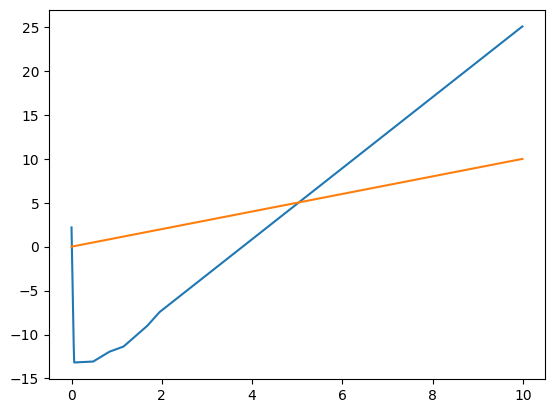

In [29]:
plt.plot([i/100 for i in range(1000)],x1x2_subnet(X1MASK).detach().numpy())
plt.plot([i/100 for i in range(1000)],[i/100 for i in range(1000)])

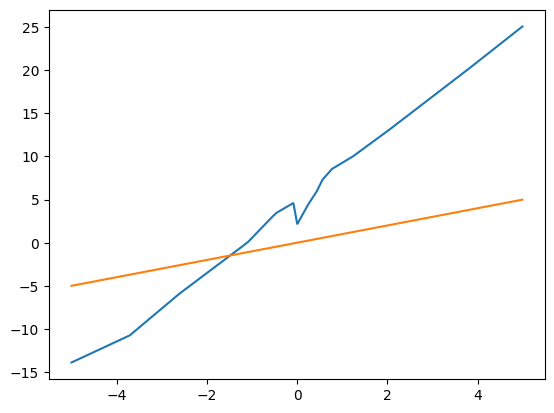

In [31]:
plt.plot([i/100 for i in range(-500,500)],x1x2_subnet(MASKX2).detach().numpy())
plt.plot([i/100 for i in range(-500,500)],[i/100 for i in range(-500,500)])

In [ ]:
plt.plot([i/100 for i in range(-500,500)],x1x2_subnet(MASKX2).detach().numpy())
plt.plot([i/100 for i in range(-500,500)],[i/100 for i in range(-500,500)])

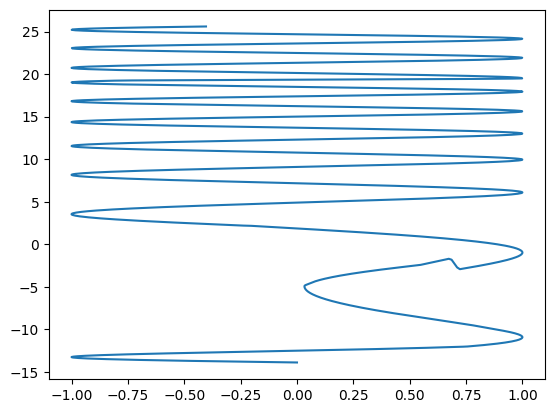

In [32]:
plt.plot(np.array(torch.sin(X1*X2)),x1x2_subnet(X1X2).detach().numpy())

### DA

In [15]:
# model = torch.load("./best_pretrained_model_VC.pt")
# model_output_s = model.output(x_s)
# latent_x_s = model_output_s['f_x']
# y_s_hat = model_output_s['output']

# model_output_t_labeled = model.output(x_t_labeled)
# latent_x_t_labeled = model_output_t_labeled['f_x']
# y_t_labeled_hat = model_output_t_labeled['output']

# model_output_t = model.output(x_t)
# latent_x_t = model_output_t['f_x']
# y_t_hat = model_output_t['output']

# # mse loss
# y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
# y_t_mse = torch.nn.functional.mse_loss(y_t_labeled_hat, y_t_labeled)
# y_t_real_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

# print(f"source mse : {y_s_mse}, labeled target mse : {y_t_mse}, target mse : {y_t_real_mse}")

In [16]:
class Mapper(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(1, 10)
        self.relu = nn.ReLU()
        self.h2 = nn.Linear(10, 10)      
        self.reg = nn.Linear(10, 1)
        
    def forward(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        h1_x = self.relu(h1_x)
        h1_x = self.reg(h1_x)
        return h1_x
    
    def output(self, x):
        h1_x = self.h1(x)
        h1_x = self.relu(h1_x)
        h1_x = self.h2(h1_x)
        f_x = self.relu(h1_x)
        y_hat = self.reg(h1_x)
        return {'f_x':f_x, 'output':y_hat}

In [18]:
experiment_num = 5
darc_original_vc_result = []
darc_original_vc_result2 = []
epoch_total_num = 5000
bn_s = len(x_s)//5
loss_list = [[0 for i in range(epoch_total_num)] for j in range(experiment_num)]
for experiment_i in range(experiment_num):
    model = Net()
    optimizer_parent = optim.Adam(model.parameters(), lr=0.001)
    best_loss = 1000
    sample = random.sample(range(len(x_s)), len(x_s)*4//5)
    val_sample = list(set(range(len(x_s))) - set(sample))
    for epoch in range(10000):
        model.train()
        optimizer_parent.zero_grad()
        batch_sample = random.sample(sample, bn_s)
        model_output_s = model.output(x_s[batch_sample])
        latent_x_s = model_output_s['f_x']
        y_s_hat = model_output_s['output']
        y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s[batch_sample])
        y_s_mse.backward()
        optimizer_parent.step()

        model.eval()
        model_output_s = model.output(x_s[val_sample])
        latent_x_s = model_output_s['f_x']
        y_s_hat = model_output_s['output']
        val_loss = torch.nn.functional.mse_loss(y_s_hat, y_s[val_sample])
        if best_loss > val_loss:
            best_loss = val_loss
            best_model = copy.deepcopy(model)
    model_output_s = model.output(x_s)
    latent_x_s = model_output_s['f_x']
    y_s_hat = model_output_s['output']

    y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s)
    y_s_true_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
    darc_original_vc_result2.append([y_s_mse.detach().item(), y_s_true_mse.detach().item()])
    print(f"source mse : {y_s_mse.detach().item()}, denoise source mse : {y_s_true_mse.detach().item()}")
    pd.DataFrame(darc_original_vc_result2, columns=['TEST MSE', 'DENOISE TEST MSE']).to_csv('SOURCE_C_RESULT.csv', index=0)
    model = copy.deepcopy(best_model)

    mapper = Mapper()
    optimizer = optim.Adam(mapper.parameters(), lr=0.001)
    bn = len(x_t_labeled)
    best_mapper = copy.deepcopy(mapper)
    best_loss = 1000

    for epoch in tqdm(range(epoch_total_num)):
        optimizer.zero_grad()
        mapper.train()
        latent_x_s = x_s
        mapper_output_t_labeled = mapper.output(x_t_labeled)
        latent_x_t_labeled = mapper_output_t_labeled['output']
        # source latent에서 batch 추출
        batch_latent_x_s_index = torch.randperm(latent_x_s.size(0))[:bn_s]
        batch_latent_x_s = latent_x_s[batch_latent_x_s_index]
        # cdd loss
        feats_toalign_S = [batch_latent_x_s, torch.tensor([1]).repeat(len(batch_latent_x_s),1)]
        feats_toalign_T = [latent_x_t_labeled, torch.tensor([1]).repeat(len(latent_x_t_labeled),1)]
        cdd = CDD(kernel_num=(10,10), kernel_mul=(2,2), num_layers=2, num_classes=1, intra_only=True)
        cdd_loss = cdd.forward(feats_toalign_S, feats_toalign_T, [bn_s], [bn])['cdd']
        # ns loss
        epsilon_k = 10
        f_s_vector = latent_x_s
        f_t_vector = latent_x_t_labeled
        from sklearn.neighbors import KNeighborsRegressor
        knn = KNeighborsRegressor(n_neighbors=epsilon_k)
        knn.fit(y_s, np.array(range(len(y_s))))
        total_ns_loss = 0
        for i in range(bn):
            best_dist = 1000
            error = 0
            neighbors = knn.kneighbors(y_t_labeled[i].reshape(-1,1))[1][0].tolist()
            for index_i in neighbors:
                temp_f_dist = torch.abs(f_t_vector[i] - f_s_vector[index_i]).norm()
                temp_y_dist = torch.abs(y_t_labeled[i] - y_s[index_i]).norm()
                if best_dist > temp_f_dist + temp_y_dist:
                    best_dist = temp_f_dist + temp_y_dist
                    error = temp_f_dist
            total_ns_loss += error
        ns_loss = total_ns_loss / bn

        total_loss = cdd_loss + ns_loss
        
        if best_loss > total_loss:
            best_loss = total_loss
            best_mapper = copy.deepcopy(mapper)
        total_loss.backward()
        optimizer.step()

        loss_list[experiment_i][epoch] = total_loss.detach().item()
    
    model_output_s = model.output(x_s)
    latent_x_s = model_output_s['f_x']
    y_s_hat = model_output_s['output']

    f_t = best_mapper.output(x_t)['output']
    model_output_t = model.output(f_t)
    latent_x_t = model_output_t['f_x']
    y_t_hat = model_output_t['output']


    # mse loss
    y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
    y_t_mse = torch.nn.functional.mse_loss(y_t_hat, y_t)
    y_t_true_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

    print(f"source mse : {y_s_mse}, target mse : {y_t_mse}, denoise mse : {y_t_true_mse}")    
    darc_original_vc_result.append([y_t_mse.detach().item(), y_t_true_mse.detach().item()])

    pd.DataFrame(y_t_hat.detach().numpy(), columns=['y_hat']).to_csv(f'DAR_C_MODEL{experiment_i}.csv', index=0)
    pd.DataFrame(darc_original_vc_result, columns=['TEST MSE', 'DENOISE TEST MSE']).to_csv('DAR_C_RESULT.csv', index=0)

source mse : 0.02549693174660206, denoise source mse : 0.015895167365670204


100%|██████████| 5000/5000 [02:11<00:00, 38.12it/s]


source mse : 0.002600962994620204, target mse : 0.03755813464522362, denoise mse : 0.026727812364697456
source mse : 0.01942354254424572, denoise source mse : 0.009508069604635239


100%|██████████| 5000/5000 [04:12<00:00, 19.78it/s]


source mse : 0.0026970095932483673, target mse : 0.05676187574863434, denoise mse : 0.04624485597014427
source mse : 0.01121566817164421, denoise source mse : 0.002533727092668414


100%|██████████| 5000/5000 [05:28<00:00, 15.23it/s]


source mse : 0.0016702847788110375, target mse : 0.022014349699020386, denoise mse : 0.010998440906405449
source mse : 0.011080879718065262, denoise source mse : 0.002194523112848401


100%|██████████| 5000/5000 [03:13<00:00, 25.78it/s]


source mse : 0.0012352995108813047, target mse : 0.02384928986430168, denoise mse : 0.013059873133897781
source mse : 0.012126225978136063, denoise source mse : 0.003028930863365531


100%|██████████| 5000/5000 [02:26<00:00, 34.16it/s]

source mse : 0.0035572098568081856, target mse : 0.10840005427598953, denoise mse : 0.09531029313802719


In [ ]:
model_output_s = model.output(x_s)
latent_x_s = model_output_s['f_x']
y_s_hat = model_output_s['output']

f_t = best_mapper.output(x_t)['output']
model_output_t = model.output(f_t)
latent_x_t = model_output_t['f_x']
y_t_hat = model_output_t['output']


# mse loss
y_s_mse = torch.nn.functional.mse_loss(y_s_hat, y_s_true)
y_t_mse = torch.nn.functional.mse_loss(y_t_hat, y_t)
y_t_true_mse = torch.nn.functional.mse_loss(y_t_hat, y_t_true)

print(f"source mse : {y_s_mse}, target mse : {y_t_mse}, denoise mse : {y_t_true_mse}")

source mse : 0.0011202256428077817, target mse : 0.0167540255934, denoise mse : 0.007176926825195551


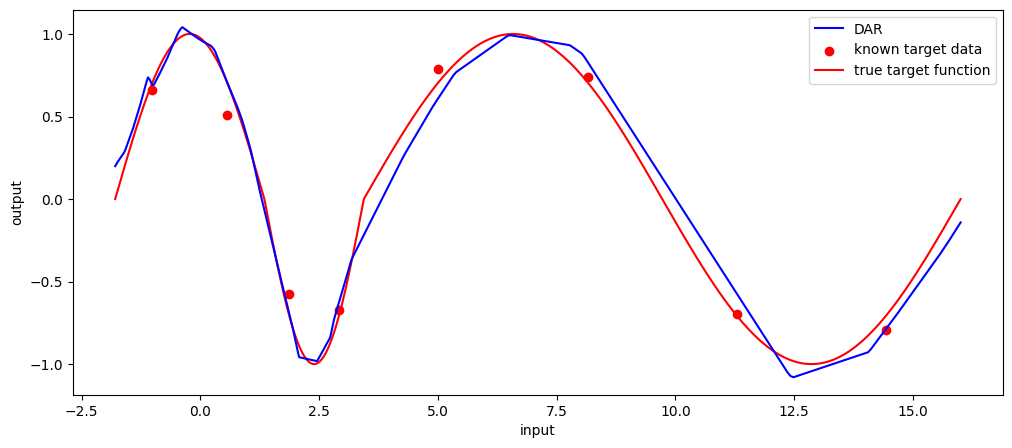

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(x_t, y_t_hat.detach().numpy(), c='blue', label='DAR', zorder=2)
plt.scatter(x_t_labeled, y_t_labeled, c='red', label='known target data', zorder=1)
plt.plot(x_t, y_t_true, c='red', label='true target function', zorder=1)
plt.xlabel('input')
plt.ylabel('output')
plt.legend()